# DATA 620 FINAL PROJECT

Project Team Members
1. Beshkia Kvarnstrom
2. Gabriel Castellanos

## INSTRUCTIONS


### Policy on Collaboration 
You may work in a team of up to three people. Each project team member is responsible for understanding and being able to explain all of the submitted project code. Remember that you can take work that you find elsewhere as a base to build on, but you need to acknowledge the source, so that I base your grade on what you contributed, not on what you started with!

### Final Project 
Your project should incorporate one or both of the two main themes of this course: network analysis and text processing. You need to show all of your work in a coherent workflow, and in a reproducible format, such as an IPython Notebook or an R Markdown document. If you are building a model or models, explain how you evaluate the “goodness” of the chosen model and parameters. 

### Final Project Presentation 
We’ll schedule a short presentation for each team, either in our last scheduled meet-up or in additional office hours to be scheduled during the last week of classes.


## INTRODUCTION:

### Guiding question or hypothesis
Does the sentiment of financial news affect .....


### Project Goals

The objective is to understand the relationship between sentiment in financial news and the behavior of financial entities in the network.

By performing sentiment analysis on news articles and analyzing the financial network, we can gain insights into how sentiment impacts financial markets and influences entities' actions.

Briefly introduce the project and its objectives.
Explain the importance of sentiment analysis in financial news and how it can impact trading decisions.
Highlight the relevance of network analysis to understand the interconnectedness of financial entities and their influence.
Data Collection:

The goal of the project is to use sentiment analysis to gain data-driven insights that can be used to predict 
the movement of financial stocks/markets. This involves first reading the data, then performing sentiment analysis, 
and finally analyzing that data, mainly using descriptive analytics to derive business insights. While graphs and 
statistical analysis will be used on the processed text, ML algorithms, and more advanced techniques will not be used. 


### Concerns
1. Transitioning and the learning curve from R to Python to build and analyze network data.
2. Effectively managing workflow between team members in a timely manner.
3. Data manipulation to present the data for the various analyses and model.


## DATA SOURCE

Describe the financial news dataset used for sentiment analysis.
Explain the attributes of the dataset, such as text content, timestamp, and source.
Mention the sources for network data, such as financial institution connections or investor relations.
Text Processing and Sentiment Analysis:

The data that will analyzed for this project was taken from Kaggle and was downloaded from here: [Financial Sentiment Analysis Dataset](https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis?select=data.csv)


In [1]:
### IMPORT REQUIRED LIBRARIES
import pandas as pd
import networkx as nx
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import TaggedDocument
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import warnings

# Download VADER lexicon for sentiment analysis (only need to do this once)
nltk.download("vader_lexicon")

# Suppress warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Beshk\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
### LOAD DATA
data_url = "https://raw.githubusercontent.com/BeshkiaKvarnstrom/DATA-620-Web-Analytics-Assignments/main/Data/financial_data.csv"

# Load the financial data into a DataFrame
Fin_df = pd.read_csv(data_url)

# Display information about the dataset
print('The Dataset contains {} rows and {} columns.'.format(Fin_df.shape[0], Fin_df.shape[1]))

Fin_df.head(10)

The Dataset contains 5842 rows and 2 columns.


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
5,$SPY wouldn't be surprised to see a green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative
8,Kone 's net sales rose by some 14 % year-on-ye...,positive
9,The Stockmann department store will have a tot...,neutral


In [3]:
Fin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [4]:
### CLEAN THE DATA

# Define a function to clean the text data
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

# Apply the cleaning function to the 'Sentence' column
Fin_df['Sentence'] = Fin_df['Sentence'].apply(cleanText)

# Preprocess the textual data by removing any leading or trailing whitespaces from the columns
Fin_df['Sentence'] = Fin_df['Sentence'].str.strip()
Fin_df['Sentiment'] = Fin_df['Sentiment'].str.strip()

# Drop any duplicate rows
Fin_df.drop_duplicates(inplace=True)

# Drop rows with missing values in 'Text' or 'Company' columns
Fin_df.dropna(subset=['Sentence', 'Sentiment'], inplace=True)


# Display the first few rows of the cleaned dataset
print('The Cleaned Dataset contains {} rows and {} columns.'.format(Fin_df.shape[0], Fin_df.shape[1]))

# Sentiments count
print("Total Positive Sentiments :", Fin_df[Fin_df.Sentiment == 'positive'].shape)
print("Total Negative Sentiments :", Fin_df[Fin_df.Sentiment == 'negative'].shape)
print("Total Nuetral Sentiments :", Fin_df[Fin_df.Sentiment == 'neutral'].shape)

Fin_df.head(10)

The Cleaned Dataset contains 5834 rows and 2 columns.
Total Positive Sentiments : (1851, 2)
Total Negative Sentiments : (859, 2)
Total Nuetral Sentiments : (3124, 2)


,Sentence,Sentiment
0,the geosolutions technology will leverage bene...,positive
1,"$esi on lows, down $1.50 to $2.50 bk a real po...",negative
2,"for the last quarter of 2010 , componenta 's n...",positive
3,according to the finnish-russian chamber of co...,neutral
4,the swedish buyout firm has sold its remaining...,neutral
5,$spy wouldn't be surprised to see a green close,positive
6,shell's $70 billion bg deal meets shareholder ...,negative
7,ssh communications security corp stock echange...,negative
8,kone 's net sales rose by some 14 % year-on-ye...,positive
9,the stockmann department store will have a tot...,neutral


<Axes: xlabel='Sentiment', ylabel='count'>

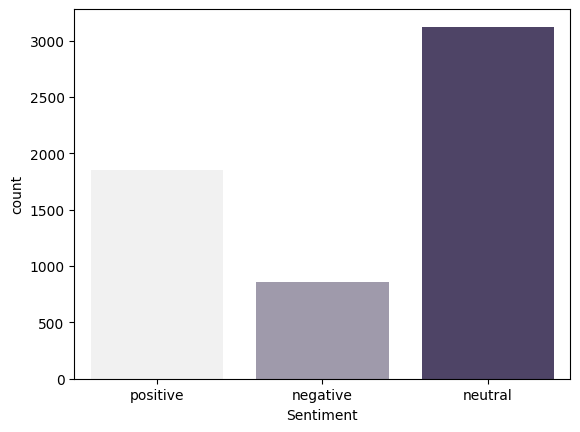

In [5]:
# Visualize the distribution of sentiments in the dataset
sns.countplot(data=Fin_df, x='Sentiment', palette='light:#4c3e6c') 

In [6]:
# Map the sentiment labels to numerical values for model training
target_map = {'neutral':2,'positive':0,'negative':1}
Fin_df['target'] = Fin_df['Sentiment'].map(target_map)
Fin_df.head()

,Sentence,Sentiment,target
0,the geosolutions technology will leverage bene...,positive,0
1,"$esi on lows, down $1.50 to $2.50 bk a real po...",negative,1
2,"for the last quarter of 2010 , componenta 's n...",positive,0
3,according to the finnish-russian chamber of co...,neutral,2
4,the swedish buyout firm has sold its remaining...,neutral,2


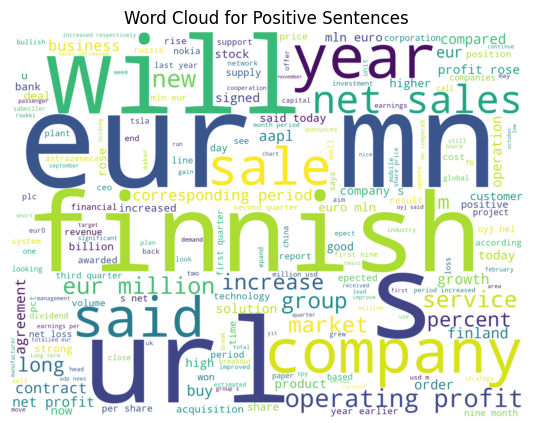

In [7]:
# Display Wordcloud - Positive Sentiment 
# Generate and display a word cloud for positive sentiment sentences
dfPos = Fin_df[Fin_df['Sentiment']=='positive']
words = ' '.join(dfPos['Sentence'].astype(str))
Cleaned_Text = ' '.join([word for word in words.split() if not word.startswith('@')])

wordcloud_Pos = WordCloud(background_color='white',stopwords=STOPWORDS, width=2000, height=1500).generate(''.join(Cleaned_Text))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_Pos, interpolation="bilinear")
plt.axis('off')
plt.title("Word Cloud for Positive Sentences")
plt.show()

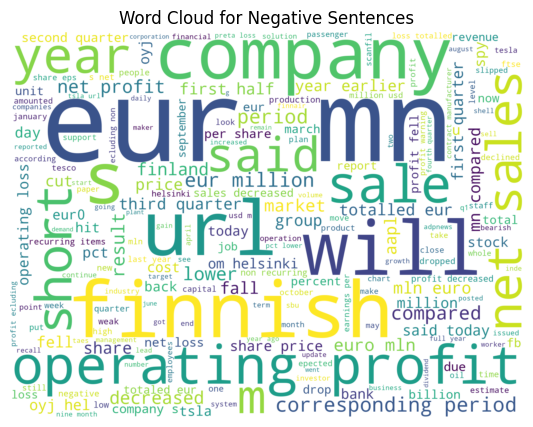

In [8]:
# Display Wordcloud - Negative Sentiment 
# Generate and display a word cloud for negative sentiment sentences
dfPos = Fin_df[Fin_df['Sentiment']=='negative']
words = ' '.join(dfPos['Sentence'].astype(str))
Cleaned_Text = ' '.join([word for word in words.split() if not word.startswith('@')])

wordcloud_Pos = WordCloud(background_color='white',stopwords=STOPWORDS, width=2000, height=1500).generate(''.join(Cleaned_Text))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_Pos, interpolation="bilinear")
plt.axis('off')
plt.title("Word Cloud for Negative Sentences")
plt.show()

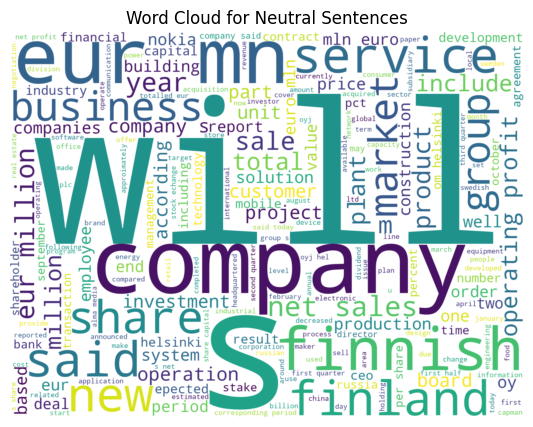

In [9]:
# Display Wordcloud - Neutral Sentiment 
# Generate and display a word cloud for neutral sentiment sentences
dfPos = Fin_df[Fin_df['Sentiment']=='neutral']
words = ' '.join(dfPos['Sentence'].astype(str))
Cleaned_Text = ' '.join([word for word in words.split() if not word.startswith('@')])

wordcloud_Pos = WordCloud(background_color='white',stopwords=STOPWORDS, width=2000, height=1500).generate(''.join(Cleaned_Text))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_Pos, interpolation="bilinear")
plt.axis('off')
plt.title("Word Cloud for Neutral Sentences")
plt.show()

In [10]:
# Perform text processing and sentiment analysis
# Initialize the Sentiment Intensity Analyzer
sid = SentimentIntensityAnalyzer()

# Define a function for text processing (cleaning) and sentiment analysis
def process_text(cleaned_text):
     # Remove lxml using BeautifulSoup
    cleaned_text = BeautifulSoup(cleaned_text, "lxml").text
    
    # Convert text to lowercase
    cleaned_text = cleaned_text.lower()

    # Remove special characters and numbers using regex
    cleaned_text = re.sub(r"[^a-zA-Z]", " ", cleaned_text)
    
    # Tokenize the text
    tokens = word_tokenize(cleaned_text)

    # Remove punctuation and stopwords
    stopwords_set = set(stopwords.words("english"))
    filtered_tokens = [word for word in tokens if word not in stopwords_set]
    
    # Join tokens back into text
    cleaned_text = " ".join(filtered_tokens)
    
    return filtered_tokens

# Apply text processing and Converting Sentences into tokens
Fin_df["filtered_tokens"] = Fin_df["Sentence"].apply(process_text)
# Fin_df["Sentiment"] = Fin_df["Sentence"].apply(lambda x: sid.polarity_scores(x)["compound"])

# Display the first few rows of the DataFrame with sentiment scores
Fin_df.head()

,Sentence,Sentiment,target,filtered_tokens
0,the geosolutions technology will leverage bene...,positive,0,"[geosolutions, technology, leverage, benefon, ..."
1,"$esi on lows, down $1.50 to $2.50 bk a real po...",negative,1,"[esi, lows, bk, real, possibility]"
2,"for the last quarter of 2010 , componenta 's n...",positive,0,"[last, quarter, componenta, net, sales, double..."
3,according to the finnish-russian chamber of co...,neutral,2,"[according, finnish, russian, chamber, commerc..."
4,the swedish buyout firm has sold its remaining...,neutral,2,"[swedish, buyout, firm, sold, remaining, perce..."


In [11]:
# Download additional NLTK resources
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')

# Additional preprocessing for word embedding
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk import word_tokenize


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Beshk\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Beshk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
Fin_df['Sentence'] = Fin_df['Sentence'].apply(cleanText)

# Split the dataset into training and testing subsets
X_train, X_test = train_test_split(Fin_df, test_size=0.10 , random_state=42)

# Function to tokenize text
def tokenize_text(cleanText):
    tokens = []
    for sent in nltk.sent_tokenize(cleanText):
        for word in nltk.word_tokenize(sent):
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens

# Apply tokenization to the 'Sentence' column
train_tagged = X_train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Sentence']), tags=[r.Sentiment]), axis=1)
test_tagged = X_test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Sentence']), tags=[r.Sentiment]), axis=1)

# Set up tokenizer and sequence padding
max_fatures = 500000
MAX_SEQUENCE_LENGTH = 50

tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(Fin_df['Sentence'].values)
X = tokenizer.texts_to_sequences(Fin_df['Sentence'].values)
X = pad_sequences(X)

print('There are %s unique tokens.' % len(X))
print('There are %d total no of Training words.' % (len(train_tagged)))
print('There are %d total no of Test words.' % (len(test_tagged)))


There are 5834 unique tokens.
There are 5250 total no of Training words.
There are 584 total no of Test words.


# Letter Analysis on Sentiments/Building NB Classifyer

After we have done some cleaning and obtained (what we believe to be good tokens for out analysis), we can take this a step further and and group anaklze the letters for our three classes of tweets: postive, negative and neutral. Ideally, we would like to see the different letters with the highest counts for each group to help distincguish them. From there we will take these new features and use them to build a Naive Bayes Classifyer the classifies positvie and negative sentences/tokens.$1^{https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk}$ 

In [13]:
# Convert 'filtered_tokens' to string format
Fin_df['filtered_tokens'] = [','.join(map(str, l)) for l in Fin_df['filtered_tokens']]


In [14]:
# Extract words for each sentiment category
Positive = Fin_df[Fin_df["Sentiment"] == 'positive']
Negative = Fin_df[Fin_df["Sentiment"] == 'negative']
Neutral = Fin_df[Fin_df["Sentiment"] == 'neutral']


In [15]:
Pos = ', '.join(Positive['filtered_tokens'])
Neg = ', '.join(Negative['filtered_tokens'])
Net = ', '.join(Neutral['filtered_tokens'])

In [16]:
# Function to get all words from a list of tokens
def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

In [17]:
# Get all words for each sentiment category
all_pos_words = get_all_words(Pos)
all_neg_words = get_all_words(Neg)
all_neut_words = get_all_words(Net)


In [18]:
# Calculate the frequency distribution of words for each sentiment category
from nltk import FreqDist

freq_dist_pos = FreqDist(all_pos_words)
print(freq_dist_pos.most_common(11))

[(',', 20787), ('e', 14842), ('r', 10428), ('a', 10032), ('n', 9762), ('i', 9695), ('s', 9300), ('o', 8752), ('t', 8388), ('l', 5856), ('c', 5060)]


In [19]:
# Function to get tweets for model training
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)
        
# Get tweets for model training for positive and negative sentiments
positive_tokens_for_model = get_tweets_for_model(Pos)
negative_tokens_for_model = get_tweets_for_model(Neg)

In [20]:
# Create datasets for model training
positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + negative_dataset

In [21]:
# Split the dataset into training and testing subsets
train_data = dataset[:7000]
test_data = dataset[7000:]

In [22]:
# Train a Naive Bayes classifier for sentiment analysis
from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data)

# Evaluate the classifier's accuracy
print("Accuracy is:", classify.accuracy(classifier, test_data))

# Show the most informative features of the classifier
print(classifier.show_most_informative_features(10))

Accuracy is: 0.6953072123388846
Most Informative Features
None


# Domain Research


Analysis like the one shown in this notebook can be used to quickly analyze the 'feelings' of user in the financial social media environment. Social media platforms such as Seeking Alpha and StockTwits are sites where financial experts and users alike can share their sentiments on stocks and the current state of the market.

Reasearchers have used DeepLearning algorithims (specifically CNNs) to try and help with these types of tasks. They are particularly appealing because of the difficulty that comes with feature engineering. It can be a arduous and time consuming process to determing which words are meaningful and which ones are considered 'noise' so deep learning models can go a long way in mitigating this issue. $2^{Sohangir, S., Wang, D., Pomeranets, A. et al. Big Data: Deep Learning for financial sentiment analysis. J Big Data 5, 3 (2018). https://doi.org/10.1186/s40537-017-0111-6}$

While this dataset is relatively small, when we are dealing with larger datasets, training time increases exponentially. 

### CONCLUSIONS
By combining sentiment analysis and network analysis in the financial domain, this project aims to provide a comprehensive understanding of how news sentiment influences financial entities' behavior and the interconnectedness of these entities in the financial ecosystem. The findings may have practical applications in investment strategies and risk assessment, benefiting investors, financial institutions, and the overall market participants.